# End-to-End Hitters Machine Learning 


    
Estimating baseball players salary applying machine learning algoritms on hitters dataset
1.  [**Exploratory Data Analysis**](#1)
2.  [**Data Preprocessing & Feature Engineering**](#2)
3.  [**Base Models**](#3)
4.  [**Automated Hyperparameter Optimization**](#4)
5.  [**Stacking & Ensemble Learning**](#5)
6.  [**Prediction for a New Observation**](#6)


# Format
* A data frame with 322 observations of major league players on the following 20 variables.
* AtBat Number of times at bat in 1986
* Hits Number of hits in 1986
* HmRun Number of home runs in 1986
* Runs Number of runs in 1986
* RBI Number of runs batted in in 1986
* Walks Number of walks in 1986
* Years Number of years in the major leagues
* CAtBat Number of times at bat during his career
* CHits Number of hits during his career
* CHmRun Number of home runs during his career
* CRuns Number of runs during his career
* CRBI Number of runs batted in during his career
* CWalks Number of walks during his career
* League A factor with levels A and N indicating player’s league at the end of 1986
* Division A factor with levels E and W indicating player’s division at the end of 1986
* PutOuts Number of put outs in 1986
* Assists Number of assists in 1986
* Errors Number of errors in 1986
* Salary 1987 annual salary on opening day in thousands of dollars
* NewLeague A factor with levels A and N indicating player’s league at the beginning of 1987

In [1]:

import warnings
import pandas as pd
import numpy as np
warnings.simplefilter(action='ignore', category=Warning)
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor

# linear models
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
# non-linear models
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)

In [3]:

df = pd.read_csv("../input/hitters/Hitters.csv")
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,293,66,1,30,29,14,1,293,66,1,30,29,14,A,E,446,33,20,NaN,A
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N



# 1. Explanatory Data Analysis


In [4]:


df.info()
df.shape  # There are 322 observation and 20 variables.
df.isnull().sum()  # There are missing values in Salary columns.


# Descriptive Analysis
# When I examine the dataset, we see that there is
# a difference between the mean and median values of the Assist variable.
# This difference is also supported by the standard deviation.
df.describe([0.05, 0.25, 0.50, 0.75, 0.95, 0.99]).T




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 20 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   AtBat      322 non-null    int64  
 1   Hits       322 non-null    int64  
 2   HmRun      322 non-null    int64  
 3   Runs       322 non-null    int64  
 4   RBI        322 non-null    int64  
 5   Walks      322 non-null    int64  
 6   Years      322 non-null    int64  
 7   CAtBat     322 non-null    int64  
 8   CHits      322 non-null    int64  
 9   CHmRun     322 non-null    int64  
 10  CRuns      322 non-null    int64  
 11  CRBI       322 non-null    int64  
 12  CWalks     322 non-null    int64  
 13  League     322 non-null    object 
 14  Division   322 non-null    object 
 15  PutOuts    322 non-null    int64  
 16  Assists    322 non-null    int64  
 17  Errors     322 non-null    int64  
 18  Salary     263 non-null    float64
 19  NewLeague  322 non-null    object 
dtypes: float64

,count,mean,std,min,5%,25%,50%,75%,95%,99%,max
AtBat,322.0,380.928571,153.404981,16.0,161.00,255.25,379.5,512.00,609.90,658.59000,687.0
Hits,322.0,101.024845,46.454741,1.0,39.00,64.00,96.0,137.00,174.00,210.79000,238.0
HmRun,322.0,10.770186,8.709037,0.0,0.00,4.00,8.0,16.00,28.95,33.00000,40.0
Runs,322.0,50.909938,26.024095,0.0,17.00,30.25,48.0,69.00,94.00,107.79000,130.0
RBI,322.0,48.027950,26.166895,0.0,14.00,28.00,44.0,64.75,96.00,112.37000,121.0
Walks,322.0,38.742236,21.639327,0.0,11.05,22.00,35.0,53.00,78.00,93.58000,105.0
Years,322.0,7.444099,4.926087,1.0,1.00,4.00,6.0,11.00,17.00,19.79000,24.0
CAtBat,322.0,2648.683230,2324.205870,19.0,216.50,816.75,1928.0,3924.25,7125.60,8749.97000,14053.0
CHits,322.0,717.571429,654.472627,4.0,54.00,209.00,508.0,1059.25,2017.15,2500.34000,4256.0
CHmRun,322.0,69.490683,86.266061,0.0,2.00,14.00,37.5,90.00,265.65,373.12000,548.0


In [5]:

def grab_col_names(dataframe, cat_th=10, car_th=20):
   

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat

    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]

    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car


# Specifying variable types
cat_cols, num_cols, cat_but_car = grab_col_names(df, cat_th=5, car_th=20)
cat_cols, num_cols, cat_but_car

Observations: 322
Variables: 20
cat_cols: 3
num_cols: 17
cat_but_car: 0
num_but_cat: 0


(['League', 'Division', 'NewLeague'],
 ['AtBat',
  'Hits',
  'HmRun',
  'Runs',
  'RBI',
  'Walks',
  'Years',
  'CAtBat',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'PutOuts',
  'Assists',
  'Errors',
  'Salary'],
 [])

In [6]:
def cat_summary(dataframe, col_name, plot=False):
    import pandas as pd
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()

   League      Ratio
A     175  54.347826
N     147  45.652174
##########################################


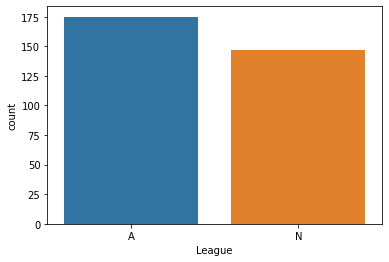

   Division      Ratio
W       165  51.242236
E       157  48.757764
##########################################


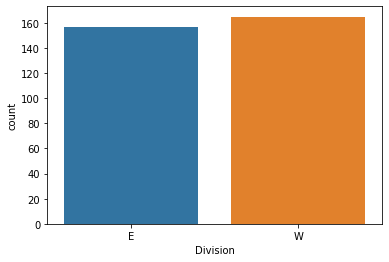

   NewLeague      Ratio
A        176  54.658385
N        146  45.341615
##########################################


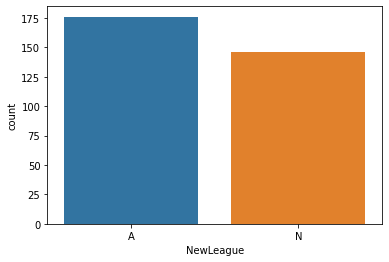

In [7]:
for col in cat_cols:
    cat_summary(df, col, plot=True)

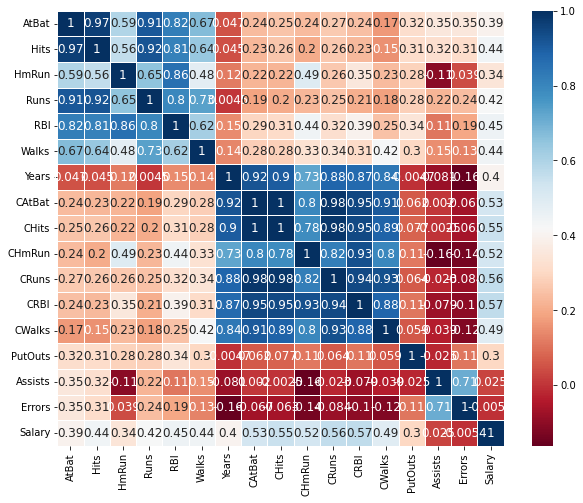

In [8]:

def correlation_matrix(df, cols):
    fig = plt.gcf()
    fig.set_size_inches(10, 8)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    fig = sns.heatmap(df[cols].corr(), annot=True, linewidths=0.5, annot_kws={'size': 12}, linecolor='w', cmap='RdBu')
    plt.show(block=True)

correlation_matrix(df, num_cols)

In [9]:

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")
    
for col in cat_cols:
    target_summary_with_cat(df, "Salary", col)

        TARGET_MEAN
League             
A        541.999547
N        529.117500


          TARGET_MEAN
Division             
E          624.271364
W          450.876873


           TARGET_MEAN
NewLeague             
A           537.113028
N           534.553852




In [10]:
df.dropna(inplace=True)

# 2. Data Preprocessing & Feature Engineering

In [11]:
def outlier_thresholds(dataframe, col_name, q1=0.10, q3=0.90):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


def check_outlier(dataframe, col_name, q1=0.10, q3=0.90):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name, q1, q3)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


In [12]:
for col in num_cols:
    print(col, check_outlier(df, col))

# We replace with thresholds
for col in num_cols:
    replace_with_thresholds(df, col)

# control for outliers
for col in num_cols:
    print(col, check_outlier(df, col))

AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits True
CHmRun True
CRuns True
CRBI False
CWalks True
PutOuts False
Assists False
Errors False
Salary False
AtBat False
Hits False
HmRun False
Runs False
RBI False
Walks False
Years False
CAtBat False
CHits False
CHmRun False
CRuns False
CRBI False
CWalks False
PutOuts False
Assists False
Errors False
Salary False


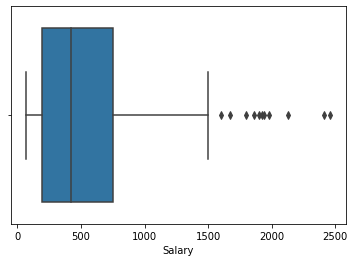

In [13]:

sns.boxplot(x=df["Salary"])
plt.show()

In [14]:

# remove salary bigger than up limit
q3 = 0.90
salary_up = int(df["Salary"].quantile(q3))
df = df[(df["Salary"] < salary_up)]


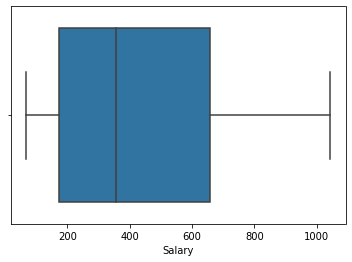

In [15]:

sns.boxplot(x=df["Salary"])
plt.show()

In [16]:

# New variables were created with the most appropriate variables according to their proportions.

df["new_Hits/CHits"] = df["Hits"] / df["CHits"]
df["new_OrtCHits"] = df["CHits"] / df["Years"]
df["new_OrtCHmRun"] = df["CHmRun"] / df["Years"]
df["new_OrtCruns"] = df["CRuns"] / df["Years"]
df["new_OrtCRBI"] = df["CRBI"] / df["Years"]
df["new_OrtCWalks"] = df["CWalks"] / df["Years"]


df["New_Average"] = df["Hits"] / df["AtBat"]
df['new_PutOutsYears'] = df['PutOuts'] * df['Years']
df["new_RBIWalksRatio"] = df["RBI"] / df["Walks"]
df["New_CHmRunCAtBatRatio"] = df["CHmRun"] / df["CAtBat"]
df["New_BattingAverage"] = df["CHits"] / df["CAtBat"]
df.dropna(inplace=True)


In [17]:
binary_cols = [col for col in df.columns if df[col].dtype not in [int, float] and df[col].nunique() == 2]
for col in binary_cols:
    labelencoder = LabelEncoder()
    df[col] = labelencoder.fit_transform(df[col])


In [18]:
df.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague,new_Hits/CHits,new_OrtCHits,new_OrtCHmRun,new_OrtCruns,new_OrtCRBI,new_OrtCWalks,New_Average,new_PutOutsYears,new_RBIWalksRatio,New_CHmRunCAtBatRatio,New_BattingAverage
1,315.0,81,7.0,24,38.0,39.0,14,3449.0,835.0,69.0,321.0,414.0,375.0,1,1,632.0,43.0,10,475.0,1,0.097006,59.642857,4.928571,22.928571,29.571429,26.785714,0.257143,8848.0,0.974359,0.020006,0.242099
2,479.0,130,18.0,66,72.0,76.0,3,1624.0,457.0,63.0,224.0,266.0,263.0,0,1,880.0,82.0,14,480.0,0,0.284464,152.333333,21.000000,74.666667,88.666667,87.666667,0.271399,2640.0,0.947368,0.038793,0.281404
3,496.0,141,20.0,65,78.0,37.0,11,5628.0,1575.0,225.0,828.0,838.0,354.0,1,0,200.0,11.0,3,500.0,1,0.089524,143.181818,20.454545,75.272727,76.181818,32.181818,0.284274,2200.0,2.108108,0.039979,0.279851
4,321.0,87,10.0,39,42.0,30.0,2,396.0,101.0,12.0,48.0,46.0,33.0,1,0,805.0,40.0,4,91.5,1,0.861386,50.500000,6.000000,24.000000,23.000000,16.500000,0.271028,1610.0,1.400000,0.030303,0.255051
5,594.0,169,4.0,74,51.0,35.0,11,4408.0,1133.0,19.0,501.0,336.0,194.0,0,1,282.0,421.0,25,750.0,0,0.149162,103.000000,1.727273,45.545455,30.545455,17.636364,0.284512,3102.0,1.457143,0.004310,0.257033


In [19]:

# One-Hot Encoding
cat_cols, num_cols, cat_but_car = grab_col_names(df)


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=False)
    return dataframe


df = one_hot_encoder(df, cat_cols)

Observations: 236
Variables: 31
cat_cols: 3
num_cols: 28
cat_but_car: 0
num_but_cat: 3


In [20]:
y = df["Salary"]
X = df.drop(["Salary"], axis=1)

In [21]:
# list feature importances for a regressor model like LGBM
pre_model = LGBMRegressor().fit(X, y)
feature_imp = pd.DataFrame({'Feature': X.columns, 'Value': pre_model.feature_importances_})
feature_imp.sort_values("Value", ascending=False)

,Feature,Value
23,new_PutOutsYears,54
24,new_RBIWalksRatio,51
13,PutOuts,51
9,CHmRun,44
6,Years,41
16,new_Hits/CHits,40
21,new_OrtCWalks,36
25,New_CHmRunCAtBatRatio,35
5,Walks,31
7,CAtBat,31


In [22]:
pre_model = RandomForestRegressor().fit(X, y)
feature_imp = pd.DataFrame({'Feature': X.columns, 'Value': pre_model.feature_importances_})
feature_imp.sort_values("Value", ascending=False)

,Feature,Value
8,CHits,0.278636
7,CAtBat,0.190378
10,CRuns,0.141545
0,AtBat,0.065390
17,new_OrtCHits,0.044071
1,Hits,0.027895
11,CRBI,0.026805
16,new_Hits/CHits,0.024114
13,PutOuts,0.015601
19,new_OrtCruns,0.014994


# 3. Base Models

In [23]:
models = [('LR', LinearRegression()),
          ("Ridge", Ridge()),
          ("Lasso", Lasso()),
          ("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          ('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor()),
          # ("CatBoost", CatBoostRegressor(verbose=False))
          ]

for name, regressor in models:
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=10, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")


RMSE: 208.2738 (LR) 
RMSE: 202.011 (Ridge) 
RMSE: 199.6219 (Lasso) 
RMSE: 220.5961 (ElasticNet) 
RMSE: 188.5584 (KNN) 
RMSE: 213.6572 (CART) 
RMSE: 153.9995 (RF) 
RMSE: 268.7786 (SVR) 
RMSE: 157.8555 (GBM) 
RMSE: 163.5608 (XGBoost) 
RMSE: 162.2267 (LightGBM) 


# 4 Automated Hyperparameter Optimization

In [24]:


rf_params = {"max_depth": [5, 8, 15, None],
             "max_features": [5, 7, "auto"],
             "min_samples_split": [3, 5, 8, 15, 20],
             "n_estimators": [600, 650, 1000]}


lightgbm_params = {"learning_rate": [0.001, 0.01, 0.1, 0.001],
                   "n_estimators": [250, 300, 500, 1500, 2500,3000],
                   "colsample_bytree": [0.1, 0.3, 0.5, 0.7, 1]}

regressors = [("RF", RandomForestRegressor(), rf_params),
              ('LightGBM', LGBMRegressor(), lightgbm_params)]

best_models = {}

In [25]:

for name, regressor, params in regressors:
    print(f"########## {name} ##########")
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=3, scoring="neg_mean_squared_error")))
    print(f"RMSE: {round(rmse, 4)} ({name}) ")

    gs_best = GridSearchCV(regressor, params, cv=3, n_jobs=-1, verbose=False).fit(X, y)

    final_model = regressor.set_params(**gs_best.best_params_)
    rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=3, scoring="neg_mean_squared_error")))
    print(f"RMSE (After): {round(rmse, 4)} ({name}) ")

    print(f"{name} best params: {gs_best.best_params_}", end="\n\n")

    best_models[name] = final_model


########## RF ##########
RMSE: 157.6659 (RF) 
RMSE (After): 153.6299 (RF) 
RF best params: {'max_depth': None, 'max_features': 7, 'min_samples_split': 5, 'n_estimators': 1000}

########## LightGBM ##########
RMSE: 163.6458 (LightGBM) 
RMSE (After): 157.3996 (LightGBM) 
LightGBM best params: {'colsample_bytree': 0.3, 'learning_rate': 0.001, 'n_estimators': 3000}



 # 5 Stacking & Ensemble Learning

In [26]:

voting_reg = VotingRegressor(estimators=[('RF', best_models["RF"]),
                                         ('LightGBM', best_models["LightGBM"])])

voting_reg.fit(X, y)

np.mean(np.sqrt(-cross_val_score(voting_reg,
                                 X, y,
                                 cv=10,
                                 scoring="neg_mean_squared_error")))


153.52732773452723

# 6 Prediction for a New Observation

In [27]:

X.columns
random_user = X.sample(1, random_state=45)  # 247 index y[y.index == 247] --> 560
voting_reg.predict(random_user)

array([536.77457962])

In [28]:
random_user.index
y[y.index == 247] 

247    560.0
Name: Salary, dtype: float64